# Emotion Recognition in Greek Speech Using Wav2Vec 2.0

**Wav2Vec 2.0** is a pretrained model for Automatic Speech Recognition (ASR) and was released in [September 2020](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) by Alexei Baevski, Michael Auli, and Alex Conneau.  Soon after the superior performance of Wav2Vec2 was demonstrated on the English ASR dataset LibriSpeech, *Facebook AI* presented XLSR-Wav2Vec2 (click [here](https://arxiv.org/abs/2006.13979)). XLSR stands for *cross-lingual  speech representations* and refers to XLSR-Wav2Vec2`s ability to learn speech representations that are useful across multiple languages.

Similar to Wav2Vec2, XLSR-Wav2Vec2 learns powerful speech representations from hundreds of thousands of hours of speech in more than 50 languages of unlabeled speech. Similar, to [BERT's masked language modeling](http://jalammar.github.io/illustrated-bert/), the model learns contextualized speech representations by randomly masking feature vectors before passing them to a transformer network.

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/xlsr_wav2vec2.png)

The authors show for the first time that massively pretraining an ASR model on cross-lingual unlabeled speech data, followed by language-specific fine-tuning on very little labeled data achieves state-of-the-art results. See Table 1-5 of the official [paper](https://arxiv.org/pdf/2006.13979.pdf).

During fine-tuning week hosted by HuggingFace, more than 300 people participated in tuning XLSR-Wav2Vec2's pretrained on low-resources ASR dataset for more than 50 languages. This model is fine-tuned using [Connectionist Temporal Classification](https://distill.pub/2017/ctc/) (CTC), an algorithm used to train neural networks for sequence-to-sequence problems and mainly in Automatic Speech Recognition and handwriting recognition. Follow this [notebook](https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Fine_Tune_XLSR_Wav2Vec2_on_Turkish_ASR_with_%F0%9F%A4%97_Transformers.ipynb#scrollTo=Gx9OdDYrCtQ1) for more information about XLSR-Wav2Vec2 fine-tuning.

This model was shown significant results in many low-resources languages. You can see the [competition board](https://paperswithcode.com/dataset/common-voice) or even testing the models from the [HuggingFace hub](https://huggingface.co/models?filter=xlsr-fine-tuning-week). 


In this notebook, we will go through how to use this model to recognize the emotional aspects of speech in a language (or even as a general view using for every classification problem). Before going any further, we need to install some handy packages and define some enviroment values.

In [1]:
%%capture

!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install jiwer
!pip install torchaudio
!pip install librosa

# Monitor the training process
# !pip install wandb

In [2]:
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
%env TRANSFORMERS_CACHE=/content/cache
%env HF_DATASETS_CACHE=/content/cache
%env CUDA_LAUNCH_BLOCKING=1

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8
env: TRANSFORMERS_CACHE=/content/cache
env: HF_DATASETS_CACHE=/content/cache
env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
# # Uncomment this part if you want to setup your wandb project

# %env WANDB_WATCH=all
# %env WANDB_LOG_MODEL=1
# %env WANDB_PROJECT=YOUR_PROJECT_NAME
# !wandb login YOUR_API_KEY --relogin

## Prepare Data

For this particular example, we use [Acted Emotional Speech Dynamic Database – AESDD](http://m3c.web.auth.gr/research/aesdd-speech-emotion-recognition/) provided by Multidisciplinary Media & Mediated Communication Research Group ([M3C](http://m3c.web.auth.gr/)). 

The Acted Emotional Speech Dynamic Database (AESDD) is a publically available speech emotion recognition dataset that contains utterances of acted emotional speech in the Greek language for five different emotions `sadness`, `disgust`, `happiness`, `anger`, and `fear`.

The dataset consists of directories of emotions; each folder includes specific emotions. We need to loop over directories and save the paths related to each class based on the directory name.

```bash
.
├── Tools\ and\ Documentation
│   ├── ESTrainer.mlapp
│   ├── Speech\ Emotion\ Recognition\ Adapted\ to\ Multimodal\ Semantic\ Repositories_documentation.pdf
│   ├── Speech\ Emotion\ Recognition\ for\ Performance\ Interaction.pdf
│   └── readme.txt
├── anger
│   ├── a01\ (1).wav
│   ├── a01\ (2).wav
│   ├── ...
├── disgust
│   ├── d01\ (1).wav
│   ├── d01\ (2).wav
│   ├── ...
├── fear
│   ├── f01\ (1).wav
│   ├── f01\ (2).wav
│   ├── ...
├── happiness
│   ├── h01\ (1).wav
│   ├── h01\ (2).wav
│   ├── ...
└── sadness
    ├── s01\ (1).wav
    ├── s01\ (2).wav
    ├── ...

6 directories, 609 files
```

Since the dataset is hosted on [Mega](https://mega.nz/#F!0ShVXY7C!-73kVoK05OjTPEA95UUvMw) and unable to access it directly, we upload the dataset on the G-drive to make this tutorial accessible.

In [ ]:
!nvidia-smi

Wed Mar 30 00:17:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install --upgrade --no-cache-dir gdown

In [ ]:
# Download the dataset from 

# !mkdir -p /content/data
# !gdown https://drive.google.com/uc?id=1_IAWexEWpH-ly_JaA5EGfZDp-_3flkN1
# !unzip -q aesdd.zip -d /content/data/
# !mv "/content/data/Acted Emotional Speech Dynamic Database/" /content/data/aesdd/

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!ls

drive  sample_data


In [ ]:
# import librosa
# # print(librosa.__version__)
# import moviepy.editor as mp

# # clip = mp.VideoFileClip("/content/drive/MyDrive/.mp4")
# # clip.audio.write_audiofile("audio.mp3")

# y, sr = librosa.load("/content/drive/My Drive/Air_Force_One.mp3")
# print("y: ", y)
# print(len(y))
# print("sr: ", sr)

0.8.1
y:  [0.         0.         0.         ... 0.00322105 0.00458863 0.00519898]
3963708
sr:  22050


In [5]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torchaudio
from sklearn.model_selection import train_test_split

import os
import sys

### RAVDESS preprocessing

In [10]:
"""
happy       192
calm        192
sad         192
angry       192
fear        192
disgust     192
surprise    192
neutral      96

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier 

(e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

e.g.) 
name: 03-01-01-01-01-02-06.wav

path:  /content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_06/03-01-01-01-01-02-06.wav
part:  ['/content/drive/My Drive/Audio_Speech_Actors_01', '24/Actor_06/03', '01', '01', '01', '01', '02', '06']
emotion:  [1]
actor:  [2]
bg:  2
"""
ravdess_path = "/content/drive/My Drive/norm_ravdess" # 1440 wav files # label = str(emotion_dict[int(part[2])])
# ravdess_path = "/content/drive/My Drive/Audio_Speech_Actors_01-24" # label = str(emotion_dict[int(part[3])])
ravdess_file_path = []
ravdess_data = []
emotion_dict = {1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}

for path in tqdm(Path(ravdess_path).glob("**/*.wav")):
    name = str(path).split('/')[6].replace(".wav", "")
    part = str(path).split('.')[0].split('-')
    label = str(emotion_dict[int(part[2])])
    
    if label == 'calm':
      label = 'neutral'
      
    try:
        # There are some broken files
        s = torchaudio.load(path)
        ravdess_data.append({
            "name": name,
            "path": path,
            "emotion": label
        })
    except Exception as e:
        pass


df = pd.DataFrame(ravdess_data)
print(df.head())


"""
Greek dataset
"""
# for path in tqdm(Path("/content/data/aesdd").glob("**/*.wav")):
#     name = str(path).split('/')[-1].split('.')[0]
#     label = str(path).split('/')[-2]
    
#     try:
#         # There are some broken files
#         s = torchaudio.load(path)
#         data.append({
#             "name": name,
#             "path": path,
#             "emotion": label
#         })
#     except Exception as e:
#         # print(str(path), e)
#         pass

#     # break

1440it [00:04, 319.50it/s]

                   name                                               path  \
0  03-01-02-01-01-01-07  /content/drive/My Drive/norm_ravdess/Actor_07/...   
1  03-01-05-01-02-01-07  /content/drive/My Drive/norm_ravdess/Actor_07/...   
2  03-01-01-01-02-02-07  /content/drive/My Drive/norm_ravdess/Actor_07/...   
3  03-01-07-01-01-02-07  /content/drive/My Drive/norm_ravdess/Actor_07/...   
4  03-01-08-02-01-01-07  /content/drive/My Drive/norm_ravdess/Actor_07/...   

    emotion  
0   neutral  
1     angry  
2   neutral  
3   disgust  
4  surprise  


'\nGreek dataset\n'

In [11]:
df['emotion'].value_counts()

neutral     288
angry       192
disgust     192
surprise    192
happy       192
sad         192
fear        192
Name: emotion, dtype: int64

In [12]:
# Filter broken and non-existed paths

print(f"Step 0: {len(df)}")

df["status"] = df["path"].apply(lambda path: True if os.path.exists(path) else None)
df = df.dropna(subset=["path"])
df = df.drop("status", 1)
print(f"Step 1: {len(df)}")

df = df.sample(frac=1)
df = df.reset_index(drop=True)
print(df.head())

Step 0: 1440
Step 1: 1440
                   name                                               path  \
0  03-01-08-01-01-02-16  /content/drive/My Drive/norm_ravdess/Actor_16/...   
1  03-01-08-01-02-02-16  /content/drive/My Drive/norm_ravdess/Actor_16/...   
2  03-01-05-02-01-01-03  /content/drive/My Drive/norm_ravdess/Actor_03/...   
3  03-01-04-02-02-02-09  /content/drive/My Drive/norm_ravdess/Actor_09/...   
4  03-01-05-01-01-02-01  /content/drive/My Drive/norm_ravdess/Actor_01/...   

    emotion  
0  surprise  
1  surprise  
2     angry  
3       sad  
4     angry  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


Let's explore how many labels (emotions) are in the dataset with what distribution.

In [13]:
print("Labels: ", df["emotion"].unique())
print()
df.groupby("emotion").count()[["path"]]

Labels:  ['surprise' 'angry' 'sad' 'neutral' 'fear' 'happy' 'disgust']



,path
emotion,
angry,192
disgust,192
fear,192
happy,192
neutral,288
sad,192
surprise,192


Let's display some random sample of the dataset and run it a couple of times to get a feeling for the audio and the emotional label.

In [12]:
import torchaudio
import librosa
import IPython.display as ipd
import numpy as np

idx = np.random.randint(0, len(df))
sample = df.iloc[idx]
path = sample["path"]
label = sample["emotion"]


print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

speech, sr = torchaudio.load(path)
speech = speech[0].numpy().squeeze()
speech = librosa.resample(np.asarray(speech), sr, 16_000)
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=16000)

ID Location: 1297
      Label: neutral



/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_12/03-01-01-01-02-02-12.wav
48000
[ 0  0 -1 ...  0  0  0]
max(data):  1202
174575


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys


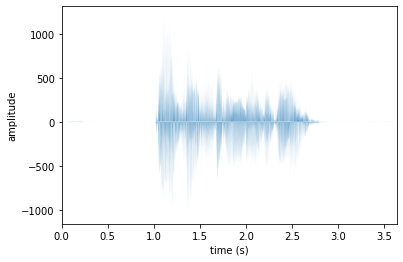

In [15]:
import numpy as np
import scipy.io as sio
import scipy.io.wavfile
import matplotlib.pyplot as plt

print(path)
samplerate, data = sio.wavfile.read(path)
print(samplerate)
print(data)
print("max(data): ", max(data))
print(len(data))
# max_data = max(data)

# data = list(map(lambda x: x / max_data, data))
scaled_data = np.float32(np.array(data / np.max(np.abs(data))))

times = np.arange(len(scaled_data))/float(samplerate)


plt.fill_between(times, data)
plt.xlim(times[0], times[-1])
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.show()

44100
[8.6569980e-06 2.6467026e-04 4.3170238e-04 ... 9.5435579e-09 2.1403965e-09
 3.9815323e-19]
max(data2):  0.5596431
182975


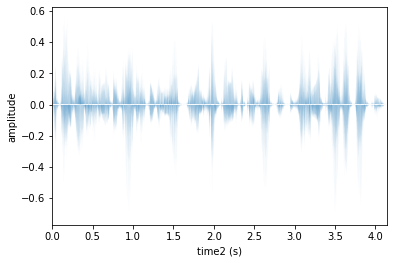

In [14]:
import numpy as np
import scipy.io as sio
import scipy.io.wavfile
import matplotlib.pyplot as plt

samplerate2, data2 = sio.wavfile.read("/content/drive/My Drive/a01 (1).wav")

print(samplerate2)
print(data2)
print("max(data2): ", max(data2))
print(len(data2))

times2 = np.arange(len(data2))/float(samplerate2)

plt.fill_between(times2, data2)
plt.xlim(times2[0], times2[-1])
plt.xlabel('time2 (s)')
plt.ylabel('amplitude')
plt.show()

For training purposes, we need to split data into train test sets; in this specific example, we break with a `20%` rate for the test set.

In [16]:
# # train/val/test = 6:2:2
# def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
#     np.random.seed(seed)
#     perm = np.random.permutation(df.index)
#     m = len(df.index)
#     train_end = int(train_percent * m)
#     validate_end = int(validate_percent * m) + train_end
#     train = df.iloc[perm[:train_end]]
#     validate = df.iloc[perm[train_end:validate_end]]
#     test = df.iloc[perm[validate_end:]]
#     return train, validate, test

# save_path = "/content/drive/My Drive/ravdess_save_path"


# train_df, validation_df, test_df = train_validate_test_split(df)

# train_df = train_df.reset_index(drop=True)
# validation_df = validation_df.reset_index(drop=True)
# test_df = test_df.reset_index(drop=True)

# train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
# validation_df.to_csv(f"{save_path}/validation.csv", sep="\t", encoding="utf-8", index=False)
# test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)

# print(train_df.shape)
# print(validation_df.shape)
# print(test_df.shape)

# # train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["emotion"])

# # train_df = train_df.reset_index(drop=True)
# # test_df = test_df.reset_index(drop=True)

# # train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
# # test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)


# # print(train_df.shape)
# # print(test_df.shape)

(864, 3)
(288, 3)
(288, 3)


In [14]:
save_path = "/content/drive/My Drive/ravdess_save_path"

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["emotion"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/validation.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)

(1152, 3)
(288, 3)


## Prepare Data for Training

In [15]:
# Loading the created dataset using datasets
from datasets import load_dataset, load_metric


data_files = {
    "train": save_path + "/train.csv",
    "validation": save_path + "/validation.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

print(train_dataset)
print(eval_dataset)

Using custom data configuration default-747f063b2b9f6e72


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /content/cache/csv/default-747f063b2b9f6e72/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 1152
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 288
})


In [16]:
# We need to specify the input and output column
input_column = "path"
output_column = "emotion"

In [17]:
# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 7 classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In order to preprocess the audio into our classification model, we need to set up the relevant Wav2Vec2 assets regarding our language in this case `lighteternal/wav2vec2-large-xlsr-53-greek` fine-tuned by [Dimitris Papadopoulos](https://huggingface.co/lighteternal/wav2vec2-large-xlsr-53-greek). To handle the context representations in any audio length we use a merge strategy plan (pooling mode) to concatenate that 3D representations into 2D representations.

There are three merge strategies `mean`, `sum`, and `max`. In this example, we achieved better results on the mean approach. In the following, we need to initiate the config and the feature extractor from the Dimitris model.

In [19]:
from transformers import AutoConfig, Wav2Vec2Processor

In [20]:
# model_name_or_path = "lighteternal/wav2vec2-large-xlsr-53-greek"
model_name_or_path = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
pooling_mode = "mean"

In [21]:
# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

In [22]:
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path,)
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

Downloading:   0%|          | 0.00/262 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/300 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

The target sampling rate: 16000


# Preprocess Data

So far, we downloaded, loaded, and split the SER dataset into train and test sets. The instantiated our strategy configuration for using context representations in our classification problem SER. Now, we need to extract features from the audio path in context representation tensors and feed them into our classification model to determine the emotion in the speech.

Since the audio file is saved in the `.wav` format, it is easy to use **[Librosa](https://librosa.org/doc/latest/index.html)** or others, but we suppose that the format may be in the `.mp3` format in case of generality. We found that the **[Torchaudio](https://pytorch.org/audio/stable/index.html)** library works best for reading in `.mp3` data.

An audio file usually stores both its values and the sampling rate with which the speech signal was digitalized. We want to store both in the dataset and write a **map(...)** function accordingly. Also, we need to handle the string labels into integers for our specific classification task in this case, the **single-label classification** you may want to use for your **regression** or even **multi-label classification**.

In [23]:
def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()

    # exception: ListArray
    if len(speech) == 2:
        speech = speech[1]
        
    return speech

def label_to_id(label, label_list):
    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]

    result = processor(speech_list, sampling_rate = target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [24]:
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)
eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

#0:   0%|          | 0/3 [00:00<?, ?ba/s]

#3:   0%|          | 0/3 [00:00<?, ?ba/s]

#1:   0%|          | 0/3 [00:00<?, ?ba/s]

#2:   0%|          | 0/3 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

In [25]:
idx = 0
print(f"Training input_values: {train_dataset[idx]['input_values']}")
print(f"Training attention_mask: {train_dataset[idx]['attention_mask']}")
print(f"Training labels: {train_dataset[idx]['labels']} - {train_dataset[idx]['emotion']}")

Training input_values: [-0.04363523796200752, -0.06471368670463562, -0.05318223312497139, -0.061697717756032944, -0.05983675271272659, -0.061221975833177567, -0.059203241020441055, -0.06171944737434387, -0.0643545538187027, -0.06206218898296356, -0.06336187571287155, -0.061880867928266525, -0.06937830150127411, -0.05856357514858246, -0.060420699417591095, -0.06772954761981964, -0.05824374407529831, -0.0590679906308651, -0.06369102746248245, -0.06235061213374138, -0.06302324682474136, -0.05961344763636589, -0.06010598689317703, -0.060575976967811584, -0.06452679634094238, -0.060403723269701004, -0.06259100884199142, -0.06694605946540833, -0.06846671551465988, -0.06577494740486145, -0.06572467088699341, -0.0657317042350769, -0.06575189530849457, -0.06260182708501816, -0.06309504806995392, -0.0671425387263298, -0.06592437624931335, -0.06515026092529297, -0.0644015371799469, -0.06846411526203156, -0.06429146975278854, -0.062071025371551514, -0.06602037698030472, -0.0639863833785057, -0.062

Great, now we've successfully read all the audio files, resampled the audio files to 16kHz, and mapped each audio to the corresponding label.

## Model

Before diving into the training part, we need to build our classification model based on the merge strategy. 

In [26]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


In [27]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


## Training

The data is processed so that we are ready to start setting up the training pipeline. We will make use of 🤗's [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, XLSR-Wav2Vec2 has a much larger input length than output length. *E.g.*, a sample of input length 50000 has an output length of no more than 100. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, fine-tuning XLSR-Wav2Vec2 requires a special padding data collator, which we will define below

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to correctly transcribe speech.

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

Without going into too many details, in contrast to the common data collators, this data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them (again making use of XLSR-Wav2Vec2's context manager). This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are **not** taken into account when computing the loss.

In [28]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2Processor


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [29]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, the evaluation metric is defined. There are many pre-defined metrics for classification/regression problems, but in this case, we would continue with just **Accuracy** for classification and **MSE** for regression. You can define other metrics on your own.

In [30]:
is_regression = False

In [31]:
import numpy as np
from transformers import EvalPrediction


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

Now, we can load the pretrained XLSR-Wav2Vec2 checkpoint into our classification model with a pooling strategy.

In [32]:
model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Some weights of the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english were not used when initializing Wav2Vec2ForSpeechClassification: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this mode

The first component of XLSR-Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretraining and as stated in the [paper](https://arxiv.org/pdf/2006.13979.pdf) does not need to be fine-tuned anymore. 
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [33]:
model.freeze_feature_extractor()

In a final step, we define all parameters related to training. 
To give more explanation on some of the parameters:
- `learning_rate` and `weight_decay` were heuristically tuned until fine-tuning has become stable. Note that those parameters strongly depend on the Common Voice dataset and might be suboptimal for other speech datasets.

For more explanations on other parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

**Note**: If one wants to save the trained models in his/her google drive the commented-out `output_dir` can be used instead.

In [34]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/wav2vec2-large-xlsr-53-english",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    num_train_epochs=1.0,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=1e-4,
    save_total_limit=2,
)

For future use we can create our training script, we do it in a simple way. You can add more on you own.

In [35]:
from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)

if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast


class CTCTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        """
        Perform a training step on a batch of inputs.

        Subclass and override to inject custom behavior.

        Args:
            model (:obj:`nn.Module`):
                The model to train.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.

                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument :obj:`labels`. Check your model's documentation for all accepted arguments.

        Return:
            :obj:`torch.Tensor`: The tensor with training loss on this batch.
        """

        model.train()
        inputs = self._prepare_inputs(inputs)

        if self.use_amp:
            with autocast():
                loss = self.compute_loss(model, inputs)
        else:
            loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        if self.use_amp:
            self.scaler.scale(loss).backward()
        elif self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.deepspeed:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()


Now, all instances can be passed to Trainer and we are ready to start training!

In [36]:
trainer = CTCTrainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.feature_extractor,
)

Using amp half precision backend


### Training

Training will take between 10 and 60 minutes depending on the GPU allocated to this notebook. 

In case you want to use this google colab to fine-tune your model, you should make sure that your training doesn't stop due to inactivity. A simple hack to prevent this is to paste the following code into the console of this tab (right mouse click -> inspect -> Console tab and insert code).

```javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```

In [37]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForSpeechClassification.forward` and have been ignored: emotion, name, path. If emotion, name, path are not expected by `Wav2Vec2ForSpeechClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1152
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 2
  Total optimization steps = 144


Step,Training Loss,Validation Loss,Accuracy
10,1.928600,2.000556,0.201389
20,1.921800,1.846232,0.329861
30,1.807600,1.775725,0.336806
40,1.755700,1.708319,0.336806
50,1.540600,1.635059,0.413194
60,1.611600,1.446760,0.354167
70,1.537300,1.499744,0.465278
80,1.422900,1.252820,0.559028
90,1.284900,1.207182,0.597222
100,1.297100,1.090721,0.642361


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForSpeechClassification.forward` and have been ignored: emotion, name, path. If emotion, name, path are not expected by `Wav2Vec2ForSpeechClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 288
  Batch size = 4
Saving model checkpoint to /content/drive/My Drive/wav2vec2-large-xlsr-53-english/checkpoint-10
Configuration saved in /content/drive/My Drive/wav2vec2-large-xlsr-53-english/checkpoint-10/config.json
Model weights saved in /content/drive/My Drive/wav2vec2-large-xlsr-53-english/checkpoint-10/pytorch_model.bin
Feature extractor saved in /content/drive/My Drive/wav2vec2-large-xlsr-53-english/checkpoint-10/preprocessor_config.json
Deleting older checkpoint [/content/drive/My Drive/wav2vec2-large-xlsr-53-english/checkpoint-90] due to args.save_total_limit
Deleting older checkpoint [/content/drive/My Drive/wav2vec2-large-xlsr-53-english

TrainOutput(global_step=144, training_loss=1.4494790501064725, metrics={'train_runtime': 794.388, 'train_samples_per_second': 1.45, 'train_steps_per_second': 0.181, 'total_flos': 1.5455526798678986e+17, 'train_loss': 1.4494790501064725, 'epoch': 1.0})

The training loss goes down and we can see that the Acurracy on the test set also improves nicely. Because this notebook is just for demonstration purposes, we can stop here.

The resulting model of this notebook has been saved to [m3hrdadfi/wav2vec2-xlsr-greek-speech-emotion-recognition](https://huggingface.co/m3hrdadfi/wav2vec2-xlsr-greek-speech-emotion-recognition)

As a final check, let's load the model and verify that it indeed has learned to recognize the emotion in the speech.

Let's first load the pretrained checkpoint.

## Evaluation

In [43]:
import librosa
from sklearn.metrics import classification_report

In [44]:
save_path = "/content/drive/My Drive/ravdess_save_path"

test_dataset = load_dataset("csv", data_files={"test": save_path + "/test.csv"}, delimiter="\t")["test"]
test_dataset

Using custom data configuration default-595d8790d94b71c6


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /content/cache/csv/default-595d8790d94b71c6/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 288
})

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


cache  drive  sample_data


In [68]:
# "jonatasgrosman/wav2vec2-large-xlsr-53-english"
# model_name_or_path = "m3hrdadfi/wav2vec2-xlsr-greek-speech-emotion-recognition"
model_name_or_path = "/content/drive/My Drive/wav2vec2-large-xlsr-53-english/checkpoint-100"

config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

loading configuration file /content/drive/My Drive/wav2vec2-large-xlsr-53-english/checkpoint-100/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "/content/drive/My Drive/wav2vec2-large-xlsr-53-english/checkpoint-100",
  "activation_dropout": 0.05,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForSpeechClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": true,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": true,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": true,
  "eos_token_id": 2,
  "feat_extract_activation": 

In [69]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)

    batch["speech"] = speech_array
    return batch


def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [70]:
test_dataset = test_dataset.map(speech_file_to_array_fn)

  0%|          | 0/288 [00:00<?, ?ex/s]

In [71]:
result = test_dataset.map(predict, batched=True, batch_size=8)

  0%|          | 0/36 [00:00<?, ?ba/s]

In [72]:
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [73]:
y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]

print(y_true[:5])
print(y_pred[:5])

[1, 3, 7, 0, 4]
[1, 3, 3, 3, 3]


In [74]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

       angry       0.73      0.31      0.43        36
        calm       0.37      0.95      0.54        42
     disgust       0.70      0.64      0.67        36
        fear       0.30      0.90      0.45        41
       happy       0.25      0.06      0.10        34
     neutral       0.00      0.00      0.00        22
         sad       1.00      0.06      0.11        36
    surprise       1.00      0.02      0.05        41

    accuracy                           0.40       288
   macro avg       0.54      0.37      0.29       288
weighted avg       0.57      0.40      0.31       288



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Prediction

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, Wav2Vec2Processor

import librosa
import IPython.display as ipd
import numpy as np
import pandas as pd

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name_or_path = "/content/drive/My Drive/wav2vec2-large-xlsr-53-english/checkpoint-100"
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
sampling_rate = processor.feature_extractor.sampling_rate
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

loading configuration file /content/drive/My Drive/wav2vec2-large-xlsr-53-english/checkpoint-100/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "/content/drive/My Drive/wav2vec2-large-xlsr-53-english/checkpoint-100",
  "activation_dropout": 0.05,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForSpeechClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": true,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": true,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": true,
  "eos_token_id": 2,
  "feat_extract_activation": 

In [79]:
def speech_file_to_array_fn(path, sampling_rate):
    speech_array, _sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech


def predict(path, sampling_rate):
    speech = speech_file_to_array_fn(path, sampling_rate)
    features = processor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits

    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    outputs = [{"Emotion": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return outputs


STYLES = """
<style>
div.display_data {
    margin: 0 auto;
    max-width: 500px;
}
table.xxx {
    margin: 50px !important;
    float: right !important;
    clear: both !important;
}
table.xxx td {
    min-width: 300px !important;
    text-align: center !important;
}
</style>
""".strip()

def prediction(df_row):
    path, emotion = df_row["path"], df_row["emotion"]
    df = pd.DataFrame([{"Emotion": emotion, "Sentence": "    "}])
    setup = {
        'border': 2,
        'show_dimensions': True,
        'justify': 'center',
        'classes': 'xxx',
        'escape': False,
    }
    ipd.display(ipd.HTML(STYLES + df.to_html(**setup) + "<br />"))
    speech, sr = torchaudio.load(path)
    speech = speech[0].numpy().squeeze()
    speech = librosa.resample(np.asarray(speech), sr, sampling_rate)
    ipd.display(ipd.Audio(data=np.asarray(speech), autoplay=True, rate=sampling_rate))

    outputs = predict(path, sampling_rate)
    r = pd.DataFrame(outputs)
    ipd.display(ipd.HTML(STYLES + r.to_html(**setup) + "<br />"))

In [80]:
# /content/drive/My Drive/wav2vec2-large-xlsr-53-english/checkpoint-100
test = pd.read_csv("/content/drive/My Drive/ravdess_save_path/test.csv", sep="\t")
test.head()

,name,path,emotion
0,03-01-02-02-01-01-01,/content/drive/My Drive/norm_ravdess/Actor_01/...,calm
1,03-01-06-02-01-01-12,/content/drive/My Drive/norm_ravdess/Actor_12/...,fear
2,03-01-08-02-02-01-12,/content/drive/My Drive/norm_ravdess/Actor_12/...,surprise
3,03-01-05-02-02-02-01,/content/drive/My Drive/norm_ravdess/Actor_01/...,angry
4,03-01-03-01-01-02-14,/content/drive/My Drive/norm_ravdess/Actor_14/...,happy


In [81]:
prediction(test.iloc[0])

,Emotion,Sentence
0,calm,


,Emotion,Score
0,angry,2.6%
1,calm,66.0%
2,disgust,6.8%
3,fear,1.9%
4,happy,5.0%
5,neutral,5.5%
6,sad,10.2%
7,surprise,2.0%


In [ ]:
prediction(test.iloc[1])

,Emotion,Sentence
0,sadness,


,Emotion,Score
0,anger,0.5%
1,disgust,0.2%
2,fear,0.1%
3,happiness,0.0%
4,sadness,99.2%


In [ ]:
prediction(test.iloc[2])

,Emotion,Sentence
0,anger,


,Emotion,Score
0,anger,99.4%
1,disgust,0.0%
2,fear,0.1%
3,happiness,0.2%
4,sadness,0.2%
